In [421]:
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, Gate
from qiskit import Aer
from typing import Union
from qiskit import assemble, transpile
from qiskit.circuit.library import TwoLocal
from qiskit.opflow import Z, I, X, Y
from qiskit.opflow import StateFn, CircuitStateFn
from qiskit.opflow import PauliExpectation, CircuitSampler
from qiskit.opflow import Gradient, NaturalGradient, QFI, Hessian
from qiskit.utils import QuantumInstance

import torch
import numpy as np

from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt


In [423]:
from qiskit.providers.aer import AerError

# Initialize a GPU backend
# Note that the cloud instance for tutorials does not have a GPU
# so this will raise an exception.
try:
    simulator_gpu = Aer.get_backend('aer_simulator')
    simulator_gpu.set_options(device='GPU')
except AerError as e:
    print(e)

In [607]:
# We will implement the efficientSU2 ansatz
def quanvolutionESU2(N_dims, gates=['rx', 'rz'], reps=1, entanglement='circular', insert_barrier=True):
    
    # Function to apply rotation gates to all of our qubits
    def rotation(gate, start):
        qc = QuantumCircuit(N_dims, name=gate)
        for i in range(N_dims):
            if gate == 'rx':
                qc.rx(parameters[start+i], i)
            if gate == 'ry':
                qc.ry(parameters[start+i], i)
            if gate == 'rz':
                qc.rz(parameters[start+i], i)
        return qc
    
    # Function apply the entanglement
    def entanglement(type=entanglement):
        qc = QuantumCircuit(N_dims, name=type)
        if (type == "circular"):
            qc.cx(N_dims-1, 0)
            for i in range(N_dims-1):
                target = i + 1
                qc.cx(i, target)
        if (type == "linear"):
            for i in range(N_dims - 1):
                target = i + 1
                qc.cx(i, target)
        if (type == "full"):
            for i in range(N_dims):
                for j in range(N_dims):
                    if (i != j):
                        qc.cx(i, j)
        return qc
    
    # Calculate the number of parameters we will need
    num_params = 2*len(gates)*N_dims*reps
    parameters = ParameterVector('theta', num_params)
    qc = QuantumCircuit(N_dims, name="EfficientSU2")
    start = 0
    
    for i in range(reps):
        for gate in gates:
            qc.compose(rotation(gate, start), range(N_dims), inplace=True)
            start += N_dims
        
        if N_dims > 1: qc.compose(entanglement(), range(N_dims), inplace=True)
        
        if (reps == 1 or i == reps-1):
            if insert_barrier: qc.barrier()
            for gate in gates:
                qc.compose(rotation(gate, start), range(N_dims), inplace=True)
                start += N_dims
        if insert_barrier: qc.barrier()
    
    return qc

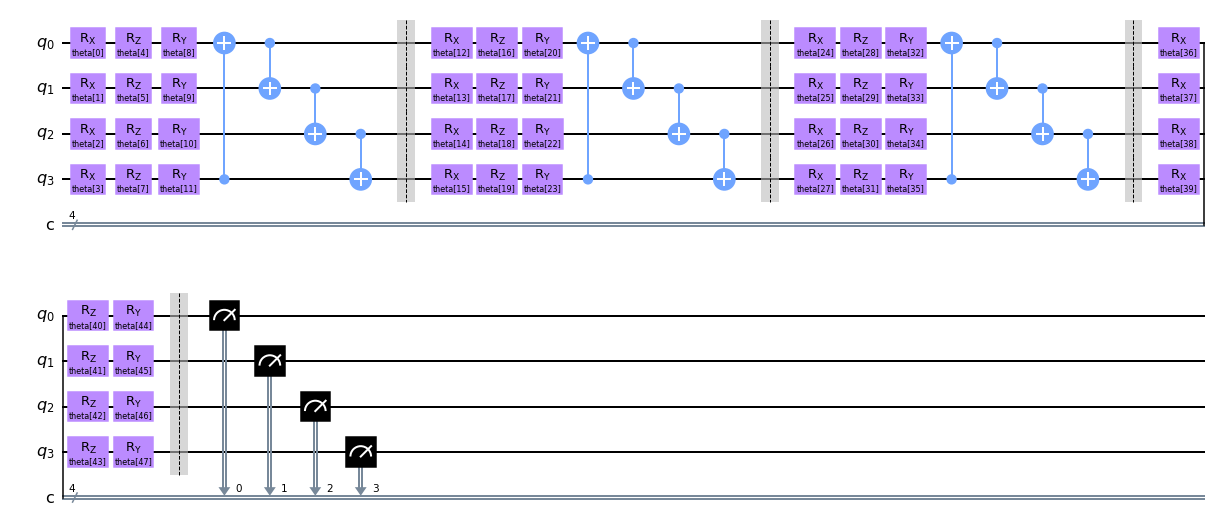

In [608]:
def randomLayer(numQbits, gates=['rx', 'rz', 'ry'], entanglement='linear', reps=1, to_gate=True) -> Union[Gate, QuantumCircuit]:
    qc = QuantumCircuit(numQbits)
    insert_barrier = False if to_gate else True 
    qc.compose(quanvolutionESU2(numQbits, gates=gates, entanglement=entanglement, reps=reps, 
                                insert_barrier=insert_barrier), inplace=True)
    return qc.to_gate(label="Random Layer") if to_gate else qc

n = 4
qc = QuantumCircuit(n,n)
qc.compose(randomLayer(n, reps=3, to_gate=False, entanglement='circular'), inplace=True)
qc.measure(range(n), range(n))
qc.draw('mpl')

In [679]:
class QC:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots, grad='param_shift', gates=['rx','ry','rz'], entanglement='linear', reps=1):
        # --- Circuit definition ---
        self._circuit = QuantumCircuit(n_qubits).compose(randomLayer(n_qubits, 
                                                                     entanglement=entanglement,
                                                                     gates=gates,
                                                                     reps = reps))
        
        all_qubits = [i for i in range(n_qubits)]
        
        self.theta = self._circuit.parameters
        
        self.nParams = self._circuit.num_parameters
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
        
        self.q_instance = QuantumInstance(self.backend, shots = self.shots, seed_simulator = 2718, seed_transpiler = 2718)
        self.sampler = CircuitSampler(self.q_instance)
        self.shifter = Gradient(grad_method=grad)  # parameter-shift rule is the default
        self.hamiltonian = Z ^ I
    
    def run(self, thetas):
        
        """t_qc = transpile(self._circuit,
                         self.backend)
        
        qobj = assemble(t_qc,
                        shots=self.shots,
                        #parameter_binds = dict(zip(self.theta, thetas))
                        parameter_binds = [{self.theta[i]: theta for i,theta in enumerate(thetas)}]
                       )
        
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)"""
        
        expectation = StateFn(self.hamiltonian, is_measurement=True) @ StateFn(self._circuit.remove_final_measurements(inplace=False))
        
        value_dict = dict(zip(self.theta, thetas))
        in_pauli_basis = PauliExpectation().convert(expectation)
        result = self.sampler.convert(in_pauli_basis, params=value_dict).eval()  
        return np.real(result)
        #return np.array([expectation])
    
    def grad(self, thetas):
        
        expectation = StateFn(self.hamiltonian, is_measurement=True) @ StateFn(self._circuit.remove_final_measurements(inplace=False))
        
        grad = self.shifter.convert(expectation)
        gradient_in_pauli_basis = PauliExpectation().convert(grad)
        value_dict = dict(zip(self.theta, thetas))

        result = self.sampler.convert(gradient_in_pauli_basis, params=value_dict).eval()
        
        return np.real(result)
        
    


In [680]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit
        expectation_z = ctx.quantum_circuit.run(input.tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        
        """shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        print(shift_right)
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor(expectation_right) - torch.tensor(expectation_left)
            print(gradient)
            gradients.append(gradient)
        gradients = np.array(gradients).T"""
        
        gradients = ctx.quantum_circuit.grad(input_list).T
        
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift, nQubits, grad='param_shift', gates=['rx','ry','rz'], entanglement='linear', reps=1):
        super(Hybrid, self).__init__()
        self.qc = QC(nQubits, backend, shots, grad=grad, gates=gates, entanglement=entanglement, reps=reps)
        self.shift = [np.pi/2 for i in range(self.qc.nParams)]
        
    def forward(self, input):
        return HybridFunction.apply(input, self.qc, self.shift)

In [579]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

AttributeError: module 'sklearn.datasets' has no attribute 'MNIST'

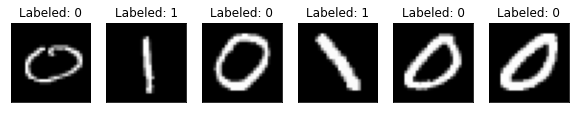

In [594]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [322]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [323]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), 16, np.pi / 2)
        n = self.hybrid.qc.nParams
        self.fc2 = nn.Linear(64, n)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

In [324]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        print(output, target)
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tensor([[0.0625, 0.9375]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([0])
tensor([[0., 1.]], dtype=torch.float64, grad_fn=<CatBackward0>) tensor([1])
tens

KeyboardInterrupt: 

Text(0, 0.5, 'Neg Log Likelihood Loss')

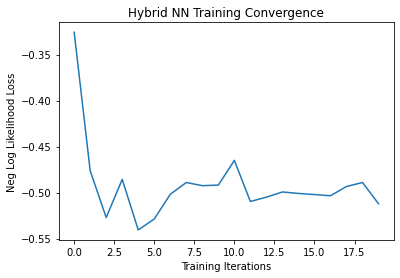

In [156]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

In [526]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler



In [681]:
def load_iris_data():
    x, y = datasets.load_iris(return_X_y=True)

    # Reduce problem to binary classification
    is_class_2 = (y == 2) 
    x = x[~is_class_2]
    y = y[~is_class_2]
    #y = y * 2 - 1  # map form {0, 1} to Z expectation values of {-1,+1}

    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, shuffle=True, random_state=123
    )

    # Standardize data (i.e. mean of 0 with unit variance)
    std_scale = StandardScaler().fit(x_train)
    x_train = std_scale.transform(x_train)
    x_test = std_scale.transform(x_test)

    # Scale to between -1 and 1
    X_std = np.append(x_train, x_test, axis=0)
    minmax_scale = MinMaxScaler((0, 1)).fit(X_std)
    x_train = minmax_scale.transform(x_train)
    x_test = minmax_scale.transform(x_test)
    return x_train, x_test, y_train, y_test

In [682]:
x_train, x_test, y_train, y_test = load_iris_data()

x_train = torch.FloatTensor(x_train)
x_test = torch.FloatTensor(x_test)
y_train = torch.DoubleTensor(y_train)
y_test = torch.DoubleTensor(y_test)

In [744]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.hybrid = Hybrid(Aer.get_backend('qasm_simulator'), 
                             1024, 
                             np.pi / 4, # This doesn't do anything right now
                             nQubits=1, 
                             grad='lin_comb',
                             entanglement='linear',
                             gates=['rx', 'ry', 'rz'],
                             reps=1)
        
        n = self.hybrid.qc.nParams
        m = 16
        self.fc1 = nn.Linear(m, n)
        self.fc2 = nn.Linear(4, m)
        self.f = nn.LeakyReLU()

    def forward(self, x):
        x = self.f(self.fc2(x))
        x = self.fc1(x)
        x = self.hybrid(x)
        x = torch.sigmoid(x)
        return x

In [745]:
model = Net()

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.BCELoss()
epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(zip(x_train, y_train.reshape(-1,1))):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()

        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

Training [5%]	Loss: 0.5505
Training [10%]	Loss: 0.3356
Training [15%]	Loss: 0.3452
Training [20%]	Loss: 0.4362
Training [25%]	Loss: 0.5102
Training [30%]	Loss: 0.6355
Training [35%]	Loss: 0.4921
Training [40%]	Loss: 0.5507
Training [45%]	Loss: 0.5727
Training [50%]	Loss: 0.6433
Training [55%]	Loss: 0.6935
Training [60%]	Loss: 0.6188
Training [65%]	Loss: 0.7237
Training [70%]	Loss: 0.6124
Training [75%]	Loss: 0.5674
Training [80%]	Loss: 0.6024
Training [85%]	Loss: 0.6371
Training [90%]	Loss: 0.7169
Training [95%]	Loss: 0.7389
Training [100%]	Loss: 0.7164


Text(0, 0.5, 'Cross Entropy Loss')

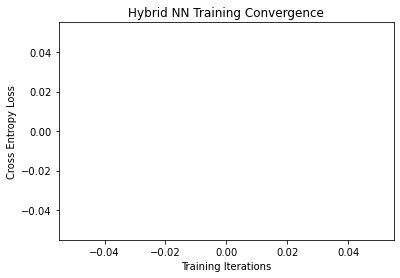

In [736]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')

In [734]:
preds = []
with torch.no_grad():
    for val in x_test:
        y_hat = model.forward(val)
        preds.append(y_hat.argmax().item())
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [704]:
print(np.sum([i if preds[i] == y_test[i] else 0 for i in range(len(y_test))]) / len(y_test))

3.95
